Here is where we will train and test a LTSM model based on the features.csv file 

In [41]:
import pandas as pd
import numpy as np
from keras.models import Sequential
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Dense, LSTM, Dropout, Conv1D, Activation, Flatten, BatchNormalization, MaxPooling1D, Bidirectional, ConvLSTM1D
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.optimizers import Adamax, Adam, RMSprop, Adadelta 
from keras.callbacks import LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import librosa
from sklearn.discriminant_analysis import StandardScaler


Configurations for training the model

In [42]:

batch_size = 64
epochs = 100
training_rate = 0.01
split = 0.2
data_size = 1
opt = Adamax(learning_rate=training_rate)
remove_emotions = []
output_size = 8-len(remove_emotions)
model_type = "CNN" # LSTM, CNN or combined
use_checkpoint = False
data_columns = "feature" # vector, feature or all

Load the datafame from features.csv and split the data into training and testing sets

In [43]:
df = pd.read_csv('dataset/features.csv')
# drop the toronto dataset
start = (7442 + 1440)*2
end = start + 2804 *2
df.drop(df.index[start:end], inplace=True)

for emotion in remove_emotions:
    df = df[df.label != emotion]
df = df.groupby('label').apply(lambda x: x.sample(frac=data_size))

labelencoder = LabelEncoder()
df['label'] = labelencoder.fit_transform(df['label'])


Decide from the config which features to use for training

In [44]:
if data_columns == "vector":
    # use only first 500 columns + last column (label)
    df = df.iloc[:, np.r_[0:500, -1]]
elif data_columns == "feature":
    # use only the last 662 - 500 columns
    df = df.iloc[:, np.r_[500:662, -1]]
elif data_columns == "all":
    # Use all data
    pass

df.head(), df.shape

(                  500       501       502       503       504       505  \
 label                                                                     
 angry 23495  0.049235  0.575105  0.603710  0.616883  0.516853  0.558547   
       12262  0.075931  0.567017  0.636744  0.627468  0.598461  0.565661   
       1360   0.183865  0.528600  0.684774  0.729402  0.707485  0.701620   
       15361  0.088669  0.389334  0.443822  0.510458  0.607281  0.706230   
       15925  0.088304  0.654331  0.765597  0.653897  0.626875  0.676151   
 
                   506       507       508       509  ...           653  \
 label                                                ...                 
 angry 23495  0.555483  0.531637  0.499072  0.482316  ...  3.972804e-06   
       12262  0.473069  0.449652  0.468237  0.532752  ...  3.931847e-06   
       1360   0.640700  0.639097  0.611095  0.513883  ...  1.508588e-02   
       15361  0.661064  0.516051  0.562027  0.519173  ...  1.054119e-06   
       15925  0.

Get X andY from the dataframe for training and testing sets

In [45]:
X = df.iloc[: ,:-1].values
Y = df['label'].values
df.head(), df.shape

(                  500       501       502       503       504       505  \
 label                                                                     
 angry 23495  0.049235  0.575105  0.603710  0.616883  0.516853  0.558547   
       12262  0.075931  0.567017  0.636744  0.627468  0.598461  0.565661   
       1360   0.183865  0.528600  0.684774  0.729402  0.707485  0.701620   
       15361  0.088669  0.389334  0.443822  0.510458  0.607281  0.706230   
       15925  0.088304  0.654331  0.765597  0.653897  0.626875  0.676151   
 
                   506       507       508       509  ...           653  \
 label                                                ...                 
 angry 23495  0.555483  0.531637  0.499072  0.482316  ...  3.972804e-06   
       12262  0.473069  0.449652  0.468237  0.532752  ...  3.931847e-06   
       1360   0.640700  0.639097  0.611095  0.513883  ...  1.508588e-02   
       15361  0.661064  0.516051  0.562027  0.519173  ...  1.054119e-06   
       15925  0.

Convert the label from categorical to numerical and split the data into training and testing sets

In [46]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [47]:

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=split, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((14972, 162), (3744, 162), (14972, 8), (3744, 8))

In [48]:

scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14972, 162), (14972, 8), (3744, 162), (3744, 8))

In [49]:
x_train = np.expand_dims(x_train, axis=2)
x_test = np.expand_dims(x_test, axis=2)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((14972, 162, 1), (14972, 8), (3744, 162, 1), (3744, 8))

Configure the learning rate callback to reduce the learning rate when the validation loss has stopped improving

In [50]:
# define the learning rate schedule callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

Configure a checkpoint callback to save the model weights after each epoch

In [51]:
# Create checkpoint every epoch callback
import os

checkpoint_path = "cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq="epoch")

In [52]:
# Define LSTM model
if model_type == "LSTM":
    model = Sequential()
    model.add(LSTM(32, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001)))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(16, kernel_regularizer=l2(0.001), recurrent_regularizer=l2(0.001))))
    model.add(Dropout(0.2))
    model.add(Flatten())
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8-(len(remove_emotions)), activation='softmax'))

In [53]:
# Define a CNN model
if model_type == "CNN":
    model = Sequential()
    model.add(Conv1D(64, output_size, padding='same', input_shape=(x_train.shape[1],1), activation='relu'))
    model.add(Conv1D(32, output_size, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Conv1D(16, output_size, padding='same', activation='relu'))
    model.add(MaxPooling1D())
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation="softmax")) 

In [54]:
# Define a combined LTSM and CNN model
if model_type == "combined":
    model = Sequential()
    model.add(LSTM(64, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    model.add(Bidirectional(LSTM(32, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(BatchNormalization())
    pretrained_model = tf.keras.models.load_model('models/model_2023-07-12_16-19-390.682.h5') # not in the repo
    pretrained_model.summary()
    for layer in pretrained_model.layers[1:-2]:
        layer.trainable = False
        model.add(layer)
    model.add(Flatten())
    model.add(Dense(y_train.shape[1], activation="softmax")) 
    
    

Build the model and give a summary

In [55]:

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_6 (Conv1D)           (None, 162, 64)           576       
                                                                 
 conv1d_7 (Conv1D)           (None, 162, 32)           16416     
                                                                 
 max_pooling1d_4 (MaxPoolin  (None, 81, 32)            0         
 g1D)                                                            
                                                                 
 conv1d_8 (Conv1D)           (None, 81, 16)            4112      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 40, 16)            0         
 g1D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 640)              

Load a checkpoint if it exists and we want to use it. Useful for continuing training

In [56]:
if "checkpoint" in os.listdir() and use_checkpoint:
    try:
        model.load_weights(checkpoint_path)
        print("Checkpoint loaded successfully")
    except:
        print("Error loading checkpoint")
else:
    print("Not using checkpoint")

Not using checkpoint


Train the model

In [57]:

history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), callbacks = [reduce_lr, cp_callback])


Epoch 1/100


233/234 [============================>.] - ETA: 0s - loss: 1.5629 - accuracy: 0.3842
Epoch 1: saving model to cp.ckpt
234/234 [==============================] - 11s 41ms/step - loss: 1.5618 - accuracy: 0.3847 - val_loss: 1.4439 - val_accuracy: 0.4391 - lr: 0.0100
Epoch 2/100
234/234 [==============================] - ETA: 0s - loss: 1.3920 - accuracy: 0.4472
Epoch 2: saving model to cp.ckpt
234/234 [==============================] - 10s 42ms/step - loss: 1.3920 - accuracy: 0.4472 - val_loss: 1.3779 - val_accuracy: 0.4509 - lr: 0.0100
Epoch 3/100
233/234 [============================>.] - ETA: 0s - loss: 1.3038 - accuracy: 0.4911
Epoch 3: saving model to cp.ckpt
234/234 [==============================] - 10s 43ms/step - loss: 1.3043 - accuracy: 0.4908 - val_loss: 1.3298 - val_accuracy: 0.4832 - lr: 0.0100
Epoch 4/100
234/234 [==============================] - ETA: 0s - loss: 1.2379 - accuracy: 0.5196
Epoch 4: saving model to cp.ckpt
234/234 [==============================] - 10s 42ms/st

Show the accuracy of the model

In [58]:

acc = model.evaluate(x_test, y_test, verbose=0)
print('Test Accuracy: %.3f' % acc[1])
print('Test Loss: %.3f' % acc[0])

Test Accuracy: 0.796
Test Loss: 0.986


Visualize training and validation accuracy  

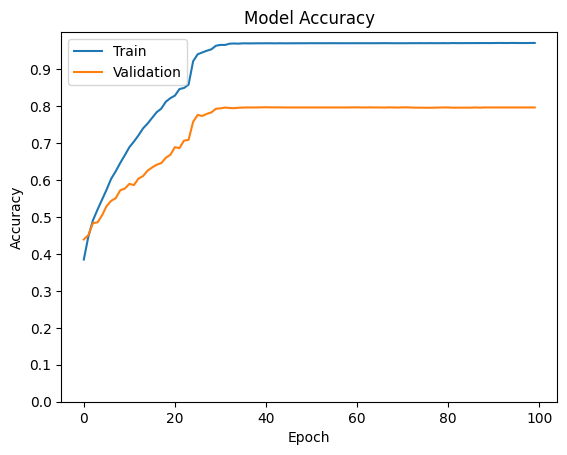

In [59]:
  
def plot_accuracy(history):
    # Plot training and validation accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    #show all accuracy values from 0 to 1
    plt.yticks(np.arange(0, 1, 0.1))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

plot_accuracy(history)

Plot the training and validation loss

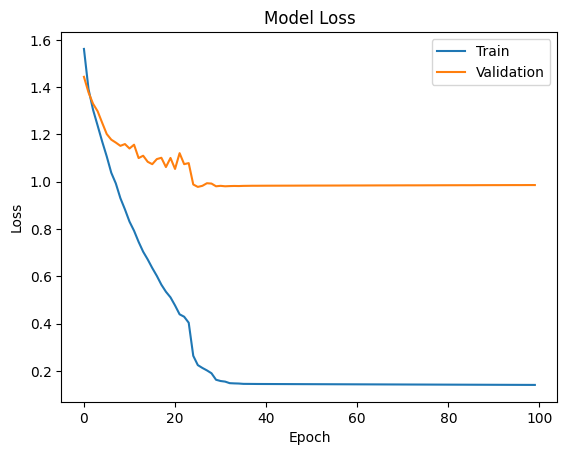

In [60]:
# Plot the training and validation loss
def plot_loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper right')
    plt.show()

plot_loss(history)  

Show the confusion matrix of the model

117/117 [==============================] - 1s 7ms/step


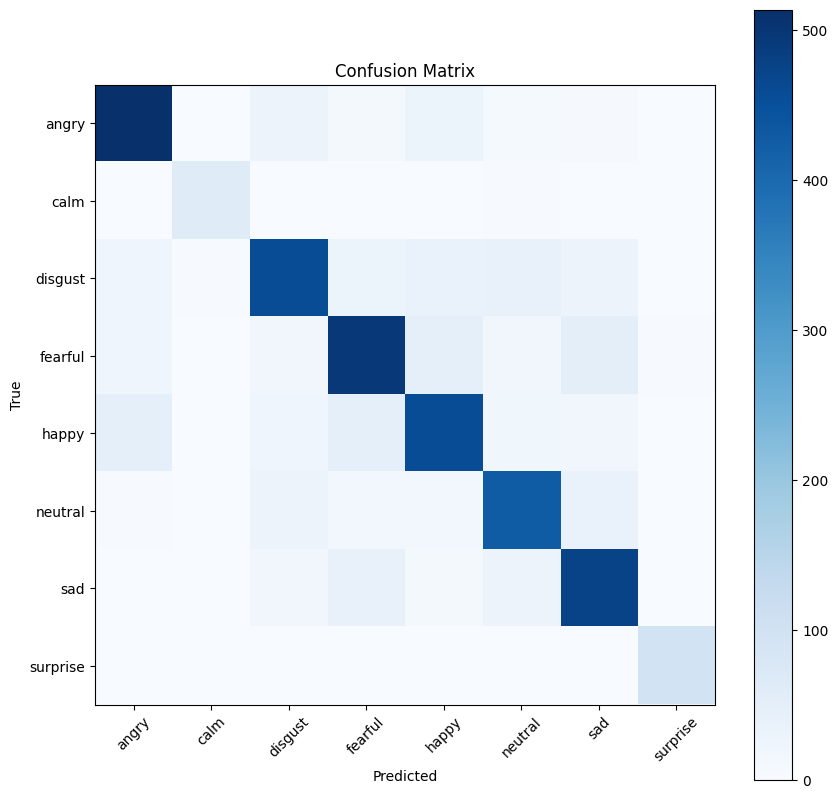

In [61]:
cm = confusion_matrix(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1))
plt.figure(figsize=(10,10))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
# convert the label from one-hot encoding to categorical
labels = ['angry', 'calm', 'disgust', 'fearful', 'happy', 'neutral', 'sad', 'surprise']
for e in remove_emotions:
    labels.remove(e)
plt.xticks(np.arange(output_size), labels, rotation=45)
plt.yticks(np.arange(output_size), labels)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.show()

Show a classification report for each emotion

In [62]:

from sklearn.metrics import classification_report
report = classification_report(y_test.argmax(axis=1), model.predict(x_test).argmax(axis=1), output_dict=True)


for label in report:
    if label == 'accuracy':
        break
    print(labels[int(label)])
    for metric in report[label]:
        print(f'\t{metric}: {report[label][metric]}')
    print('\n')

117/117 [==============================] - 1s 5ms/step
angry
	precision: 0.8453947368421053
	recall: 0.8638655462184874
	f1-score: 0.8545303408146301
	support: 595.0


calm
	precision: 0.8840579710144928
	recall: 0.8591549295774648
	f1-score: 0.8714285714285713
	support: 71.0


disgust
	precision: 0.7961672473867596
	recall: 0.7418831168831169
	f1-score: 0.7680672268907562
	support: 616.0


fearful
	precision: 0.7789968652037618
	recall: 0.756468797564688
	f1-score: 0.7675675675675676
	support: 657.0


happy
	precision: 0.7651006711409396
	recall: 0.7524752475247525
	f1-score: 0.7587354409317805
	support: 606.0


neutral
	precision: 0.7874306839186691
	recall: 0.8129770992366412
	f1-score: 0.7999999999999999
	support: 524.0


sad
	precision: 0.7694805194805194
	recall: 0.8272251308900523
	f1-score: 0.7973086627417999
	support: 573.0


surprise
	precision: 0.9411764705882353
	recall: 0.9411764705882353
	f1-score: 0.9411764705882353
	support: 102.0




Save the model so it can be used later

In [63]:
# save the model
datetime = pd.Timestamp.now().strftime(format='%Y-%m-%d_%H-%M-%S')
model.save('models/model_' + datetime +'%.3f' % acc[1] +'.h5')

/Users/terencestenvold/.pyenv/versions/3.11.3/lib/python3.11/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
